<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

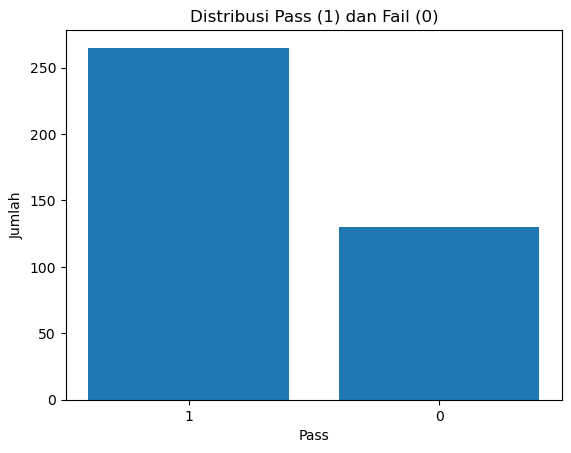

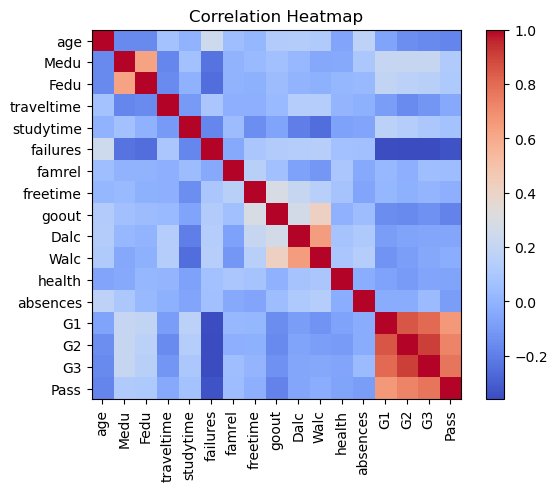


Model: LogisticRegression
accuracy: 0.633
precision: 0.707
recall: 0.774
f1: 0.739

Model: RandomForest
accuracy: 0.684
precision: 0.706
recall: 0.906
f1: 0.793

Model: KNN
accuracy: 0.608
precision: 0.662
recall: 0.849
f1: 0.744

Best Model: RandomForest dengan F1 = 0.793

Confusion Matrix:
[[ 6 20]
 [ 5 48]]

Performance setelah feature selection:
Accuracy: 0.7088607594936709
F1: 0.8034188034188035


['output_models/top20_features.joblib']

In [3]:
# ===============================
# Stage 1: Dataset Selection & Exploration
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load dataset
df = pd.read_csv("student_data.csv")

# 2. Tambahkan kolom Pass/Fail (threshold G3 >= 10)
df['Pass'] = (df['G3'] >= 10).astype(int)

# 3. Info umum dataset
print(df.info())
print(df.describe())

# 4. Distribusi kelas
print(df['Pass'].value_counts())

plt.bar(df['Pass'].value_counts().index.astype(str),
        df['Pass'].value_counts().values)
plt.title("Distribusi Pass (1) dan Fail (0)")
plt.xlabel("Pass")
plt.ylabel("Jumlah")
plt.show()

# 5. Korelasi numerik
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()

# ===============================
# Stage 2: Data Preprocessing
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Buang kolom nilai ujian awal dan target numerik asli
X = df.drop(columns=['G1', 'G2', 'G3', 'Pass'])
y = df['Pass']

# One-hot encoding untuk variabel kategorik
X_enc = pd.get_dummies(X, drop_first=True)

# Scaling numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)

# Split dataset dengan stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# Stage 3: Model Training & Comparison
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Inisialisasi model
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

# Ringkasan hasil
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, score in metrics.items():
        print(f"{metric_name}: {score:.3f}")

# ===============================
# Stage 4: Model Selection
# ===============================
best_model_name = max(results, key=lambda m: results[m]['f1'])
print(f"\nBest Model: {best_model_name} dengan F1 = {results[best_model_name]['f1']:.3f}")

best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))
print("\nConfusion Matrix:")
print(cm)

# ===============================
# Stage 5: Documentation & Interpretation
# ===============================
# (Interpretasi ditulis di laporan, bukan di code)

# ===============================
# Stage 6: Model Improvement
# ===============================
from sklearn.ensemble import RandomForestClassifier

# Feature importance dengan RandomForest
rf_fs = RandomForestClassifier(n_estimators=200, random_state=42)
rf_fs.fit(X_train, y_train)
importances = pd.Series(rf_fs.feature_importances_, index=X_enc.columns).sort_values(ascending=False)

# Ambil top 20 fitur
top20 = importances.head(20).index.tolist()
X_enc_top20 = X_enc[top20]
X_top_scaled = scaler.fit_transform(X_enc_top20)

Xtr_t, Xte_t, ytr_t, yte_t = train_test_split(
    X_top_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Retrain best model dengan fitur terpilih
best_model.fit(Xtr_t, ytr_t)
y_pred_top = best_model.predict(Xte_t)

print("\nPerformance setelah feature selection:")
print("Accuracy:", accuracy_score(yte_t, y_pred_top))
print("F1:", f1_score(yte_t, y_pred_top))

# ===============================
# Save Model untuk Deployment
# ===============================
import joblib
import os

os.makedirs("output_models", exist_ok=True)
joblib.dump(best_model, "output_models/best_model.joblib")
joblib.dump(scaler, "output_models/scaler.joblib")
joblib.dump(top20, "output_models/top20_features.joblib")
